In [53]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Utilities
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Balancing Datasets
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# Creating Pipeline
from imblearn.pipeline import Pipeline

In [3]:
# Load Train and Test data
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [4]:
# Splitting into X and y
X_train = train.drop("DEFAULT", axis=1)
y_train = train["DEFAULT"]
X_test = test.drop("DEFAULT", axis=1)
y_test = test["DEFAULT"]

In [5]:
# Base Models for experimenting
base_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42)
}

As the Default rate is 22% showing imbalance in data. It will be worth to experiment with balancing methods

In [6]:
# Balancing methods experiments
balancing_methods = {
    "No Balancing": None,
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "Tomek Links": TomekLinks(),
    "SMOTE + Tomek Links": SMOTETomek(random_state=42)
}

In [7]:
# Evalution function
def evaluate_model(model, X_test, y_test):
    """Evaluates the model using AUC, Recall, and F1-score."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return auc, recall, f1

In [8]:
results = []

for balance_name, balancer in balancing_methods.items():
    for model_name, model in base_models.items():
        print(f"Balancing: {balance_name} | Model: {model_name}")

        steps = []
        if balancer is not None:
            steps.append(('balancer', balancer))

        steps.append(('classifier', model))

        # Use Pipeline
        pipe = Pipeline(steps)

        # Train model
        pipe.fit(X_train, y_train)

        # Evaluate
        auc, recall, f1 = evaluate_model(pipe, X_test, y_test)
        results.append((balance_name, model_name, auc, recall, f1))

        print(f"AUC: {auc:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")

Balancing: No Balancing | Model: Random Forest
AUC: 0.7545 | Recall: 0.3640 | F1: 0.4633

Balancing: No Balancing | Model: XGBoost
AUC: 0.7575 | Recall: 0.3580 | F1: 0.4554

Balancing: No Balancing | Model: LightGBM
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3264
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
AUC: 0.7787 | Recall: 0.3617 | F1: 0.4669

Balancing: Random Oversampling | Model: Random Forest
AUC: 0.7566 | Recall: 0.4197 | F1: 0.4850

Balancing: Random Oversampling | Model: XGBoost
AUC: 0.7567 | Recall: 0.5697 | F1: 0.51

In [9]:
results_df = pd.DataFrame(results, columns=['Balancing', 'Model', 'AUC', 'Recall', 'F1'])
results_df = results_df.sort_values(by='Recall', ascending=False).reset_index(drop=True)

print(results_df)

               Balancing          Model       AUC    Recall        F1
0   Random Undersampling        XGBoost  0.752886  0.648078  0.499419
1   Random Undersampling       LightGBM  0.769119  0.632253  0.519666
2   Random Undersampling  Random Forest  0.757201  0.620950  0.514518
3    Random Oversampling       LightGBM  0.773687  0.605124  0.533555
4    Random Oversampling        XGBoost  0.756694  0.569706  0.511848
5                  SMOTE  Random Forest  0.747878  0.471741  0.506268
6    SMOTE + Tomek Links  Random Forest  0.749814  0.466466  0.500000
7    SMOTE + Tomek Links       LightGBM  0.767757  0.427280  0.497368
8                  SMOTE       LightGBM  0.769508  0.421251  0.497996
9    Random Oversampling  Random Forest  0.756576  0.419744  0.484980
10   SMOTE + Tomek Links        XGBoost  0.747019  0.411454  0.470284
11                 SMOTE        XGBoost  0.747975  0.411454  0.471299
12           Tomek Links  Random Forest  0.756575  0.406179  0.484277
13           Tomek L

In [10]:
results_df.to_csv("model_balancing_results.csv", index=False)

#### Performing hyperparameter tuning for XGBoost model with Random Undersampling as it has highest Recall value. Since the focus is to determine maximum defaulters.

In [12]:
balancer = RandomUnderSampler(random_state=42)
xgbm = XGBClassifier(random_state=42)

In [14]:
pipe = Pipeline(steps=[
    ('balancer', balancer),
    ('classifier', xgbm)
])

### Hyperparameter tuning first iteration

In [13]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [7, 9],
    'classifier__num_leaves': [15, 31],
    'classifier__subsample': [0.8, 1.0]
}

In [15]:
scoring = {'AUC': 'roc_auc', 'Recall': 'recall'}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit='Recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [16]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:35:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "num_leaves" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('balancer',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=No...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [7, 9],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__num_leaves': [15, 31],
                         'classifier__subsample': [0.8, 1.0]},
             refit='Recall', scoring={'AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=2)

In [17]:
print("Cross-validation results summary:")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['mean_test_AUC', 'mean_test_Recall', 'params']].sort_values(by='mean_test_Recall', ascending=False).head())

Cross-validation results summary:
    mean_test_AUC  mean_test_Recall  \
32       0.763385          0.664156   
34       0.763385          0.664156   
38       0.769232          0.663968   
36       0.769232          0.663968   
30       0.766614          0.663590   

                                               params  
32  {'classifier__learning_rate': 0.1, 'classifier...  
34  {'classifier__learning_rate': 0.1, 'classifier...  
38  {'classifier__learning_rate': 0.1, 'classifier...  
36  {'classifier__learning_rate': 0.1, 'classifier...  
30  {'classifier__learning_rate': 0.1, 'classifier...  


In [19]:
print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nBest Recall During CV:")
print(grid_search.best_score_)

Best Parameters Found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__num_leaves': 15, 'classifier__subsample': 0.8}

Best Recall During CV:
0.664156154429162


In [42]:
# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Core Metrics
auc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Best Parameters Found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__num_leaves': 10, 'classifier__subsample': 0.8}

Best Recall During CV:
0.664156154429162

Test Set Performance:

AUC: 0.7517 | Recall: 0.6353 | F1: 0.4953

Classification Report:
              precision    recall  f1-score   support

           0     0.8766    0.7359    0.8001      4673
           1     0.4059    0.6353    0.4953      1327

    accuracy                         0.7137      6000
   macro avg     0.6412    0.6856    0.6477      6000
weighted avg     0.7725    0.7137    0.7327      6000

Confusion Matrix:
          Pred 0  Pred 1
Actual 0    3439    1234
Actual 1     484     843


In [44]:
# Print key metrics
print(f"Test Set Performance:")
print(f"\nAUC: {auc:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

Test Set Performance:

AUC: 0.7517 | Recall: 0.6353 | F1: 0.4953


In [45]:
# Detailed evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      4673
           1       0.41      0.64      0.50      1327

    accuracy                           0.71      6000
   macro avg       0.64      0.69      0.65      6000
weighted avg       0.77      0.71      0.73      6000



In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
          Pred 0  Pred 1
Actual 0    3439    1234
Actual 1     484     843


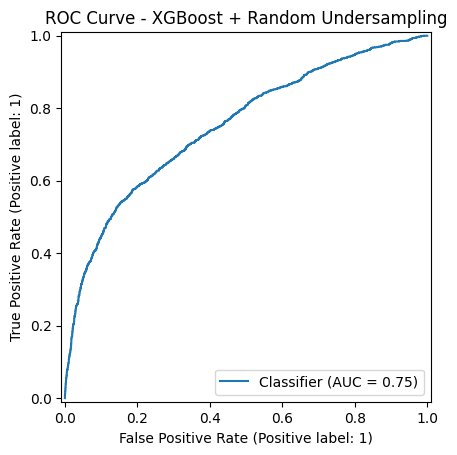

In [54]:
# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("ROC Curve - XGBoost + Random Undersampling")
plt.show()

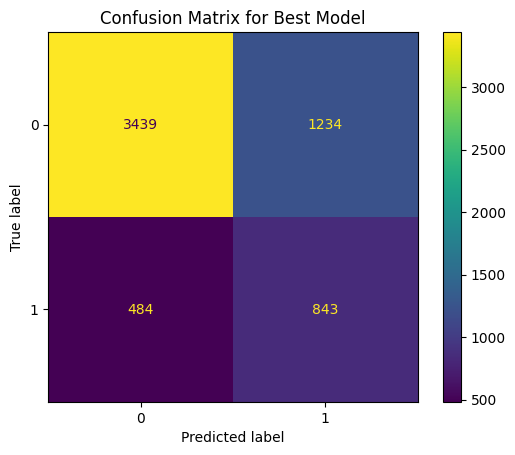

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix for Best Model')
plt.show()